In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

import torch
from torch import nn

from utils import get_gaussian_targets
from models import RNN
from train import test, pre_train, train, train_simple, set_optimimal_w_out
from viz import plot_stability, plot_state_traj

In [2]:
# set meta-parameters
# for plotting style
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)
# for pytorch tensors
device = 'cpu'
# for reproducibility while troubleshooting; numpy is for model sparse conns
torch.random.manual_seed(95214)
np.random.seed(35107)

/home/ryan/time_coding/train.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Test loss: 0.492819
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Test loss: 0.155006


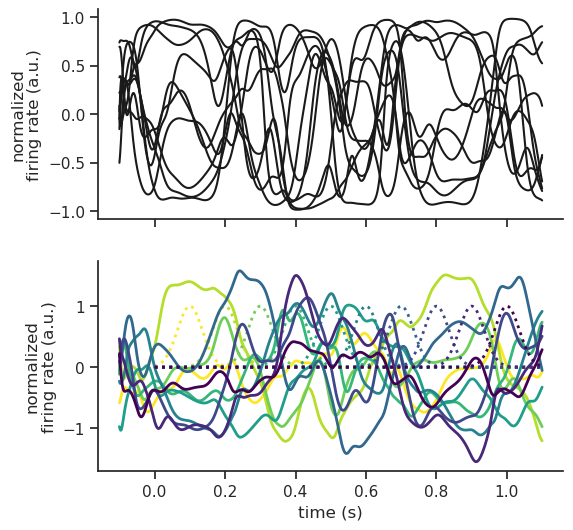

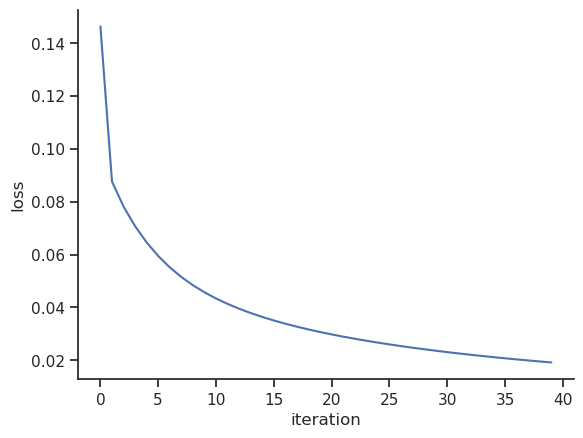

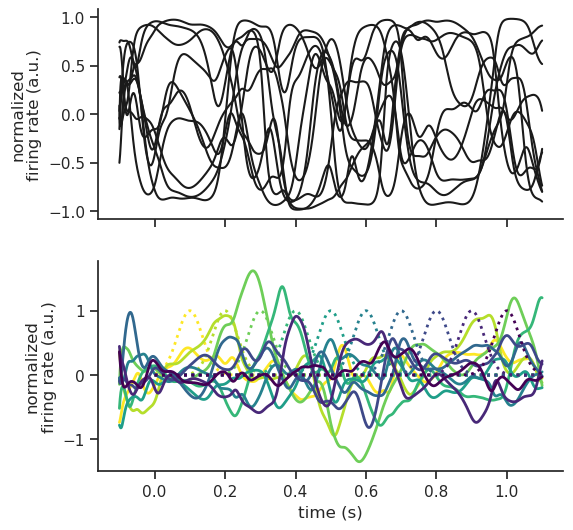

In [3]:
# instantiate model, loss function, and optimizer
n_inputs, n_hidden, n_outputs = 1, 300, 10
model = RNN(n_inputs=n_inputs, n_hidden=n_hidden,
            n_outputs=n_outputs, echo_state=False)
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# set parameters
# simulation parameters
dt = 1e-3  # 1 ms
tstop = 1.1  # 1 sec
times = np.arange(-0.1, tstop, dt)
n_times = len(times)

# define inputs (for contextual modulation / recurrent perturbations)
n_batches = 1
inputs = torch.zeros((n_batches, n_times, n_inputs))

# define output targets
# set std s.t. amplitude decays to 1/e at intersection with next target
targ_std = 0.05 / np.sqrt(2)  # ~35 ms
targets, delay_times_ = get_gaussian_targets(n_batches, n_outputs, times,
                                             targ_std)

# set initial conditions of recurrent units fixed across iterations of
# training and testing
h_0 = (torch.rand(n_hidden) * 2) - 1  # uniform in (-1, 1)
h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch

# run opt routine
# move to desired device
inputs = inputs.to(device)
targets = targets.to(device)
h_0 = h_0.to(device)

# plot model output before training
_, _ = test(inputs, targets, times, model, loss_fn, h_0, plot=True)

# pre-train
# max_iter_pretrain = 10
# for iter_idx in range(max_iter_pretrain):
#     _ = pre_train(inputs, times, model, h_0)

# train model weights
max_iter = 40
convergence_reached = False
loss_per_iter = list()
for iter_idx in range(max_iter):
    print(f"Iteration {iter_idx + 1}")
    loss, param_dist = train(inputs, targets, times, model, loss_fn,
                             optimizer, h_0)
    loss_per_iter.append(loss)
    # if param_dist < 2e-4:
    #     convergence_reached = True
    #     break
# print(f"Trial {sample_idx} training complete!!")
# if not convergence_reached:
#     print(f"Warning: didn't converge (param_dist={param_dist})!!")

# plot loss across training
plt.figure()
plt.plot(loss_per_iter)
plt.xlabel('iteration')
plt.ylabel('loss')

# investigate fitted model
# plot model output after training
h_t, loss = test(inputs, targets, times, model, loss_fn, h_0, plot=True)
h_t_batch = h_t.cpu().squeeze()

In [4]:
from cycler import cycler

def plot_state_traj(h_units, outputs, targets, times, syn_util=None):
    # NB: assumes a single batch/trial
    n_times, n_hidden = h_units.shape
    n_outputs = outputs.shape[1]

    time_mask = times > 0
    times_after_zero = times[time_mask]

    n_hidden_plot = 10  # number of hidden units to plot
    if n_hidden < 10:
        n_hidden_plot = n_hidden

    # colors = plt.cm.binary(np.linspace(0.2, 1, n_outputs))
    colors_output = plt.cm.viridis_r(np.linspace(0, 1, n_outputs))
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

    # recurrent unit trajectories
    cm_hidden = sns.color_palette('colorblind')
    axes[0].set_prop_cycle(cycler('color', cm_hidden))
    axes[0].plot(times, h_units[:, :n_hidden_plot])
    axes[0].set_ylabel('normalized\nfiring rate (a.u.)')

    # synaptic utilization (from STP)
    axes[1].set_prop_cycle(cycler('color', cm_hidden))
    axes[1].plot(times, syn_util[:, :n_hidden_plot])
    axes[1].set_ylabel('synaptic\nefficacy')

    # outputs
    for out_idx, color in zip(range(n_outputs), colors_output):
        axes[2].plot(times, outputs[:, out_idx], c=color, lw=2)
        axes[2].plot(times_after_zero, targets[time_mask, out_idx], c=color,
                     lw=2, ls=':')

    axes[2].set_xticks(np.arange(0, 1.2, 0.2))
    axes[2].set_xlabel('time (s)')
    axes[2].set_ylabel('normalized\nfiring rate (a.u.)')

    return fig

/tmp/ipykernel_83537/815823488.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


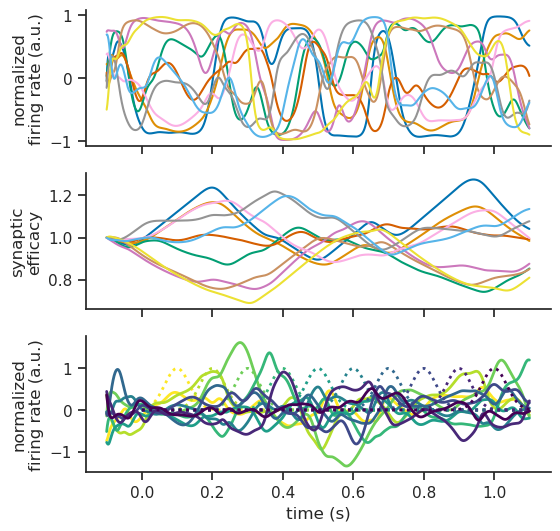

In [5]:
dt = times[1] - times[0]
model.eval()

with torch.no_grad():

    # Compute prediction error
    outputs, h_t, u_t = model(inputs, h_0=h_0, dt=dt)
    loss = loss_fn(outputs[:, times > 0, :], targets[:, times > 0, :])

# select first batch if more than one exists
hidden_batch = torch.tanh(h_t).cpu()[0]
syn_util_batch = u_t.cpu()[0]
outputs_batch = outputs.cpu()[0]
targets_batch = targets.cpu()[0]

fig = plot_state_traj(h_units=hidden_batch, outputs=outputs_batch,
                      targets=targets_batch, times=times, syn_util=syn_util_batch)
fig.show()

/tmp/ipykernel_82976/815823488.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


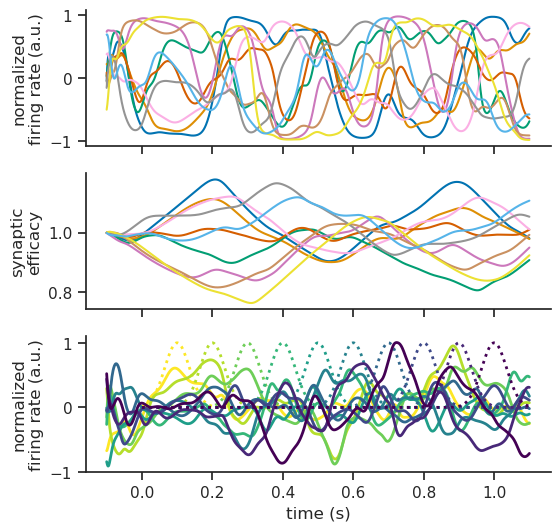

In [6]:
dt = times[1] - times[0]
model.eval()

with torch.no_grad():

    # Compute prediction error
    outputs, h_t, u_t = model(inputs, h_0=h_0, dt=dt)
    loss = loss_fn(outputs[:, times > 0, :], targets[:, times > 0, :])

# select first batch if more than one exists
hidden_batch = torch.tanh(h_t).cpu()[0]
syn_util_batch = u_t.cpu()[0]
outputs_batch = outputs.cpu()[0]
targets_batch = targets.cpu()[0]

fig = plot_state_traj(h_units=hidden_batch, outputs=outputs_batch,
                      targets=targets_batch, times=times, syn_util=syn_util_batch)
fig.show()